# Estimating the Average Treatment Effect (ATE) with Meta Learners in EconML 
In this notebook, we will explore how to estimate the Average Treatment Effect (ATE) using meta learners. We will utilize the National Supported Work Demonstration dataset to illustrate this process.


In [1]:
import dowhy
from dowhy import CausalModel
from dowhy import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt

# Avoiding unnecessary log messges and warnings
import logging
logging.getLogger("dowhy").setLevel(logging.WARNING)
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)


## 1. Dataset
This dataset is derived from an employment program conducted by Lalonde in the 1970s, which aimed to assist disadvantaged workers in the U.S. in securing long-term employment through job training.
The dataset comprises individuals categorized as either treated or control, with features such as age, ethnicity, marital status, education level, and real earnings before and after the program. 

In [2]:
# Load the data
data = dowhy.datasets.lalonde_dataset()
data.head()

,treat,age,educ,black,hisp,married,nodegr,re74,re75,re78,u74,u75
0,False,23.0,10.0,1.0,0.0,0.0,1.0,0.0,0.0,0.00,1.0,1.0
1,False,26.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,12383.68,1.0,1.0
2,False,22.0,9.0,1.0,0.0,0.0,1.0,0.0,0.0,0.00,1.0,1.0
3,False,18.0,9.0,1.0,0.0,0.0,1.0,0.0,0.0,10740.08,1.0,1.0
4,False,45.0,11.0,1.0,0.0,0.0,1.0,0.0,0.0,11796.47,1.0,1.0


The dataset contains 445 samples, with 58% of the samples having actually participated in the program and 42% not having participated.


In [3]:
print('Total number of samples: {}'.format(len(data)))

Total number of samples: 445


In [4]:
data['treat'].value_counts(normalize = True)

treat
False    0.58427
True     0.41573
Name: proportion, dtype: float64

## 2. Framing
In this section, we will define a causal model using the DoWhy library. A causal model helps us understand the cause-and-effect relationship between variables. 
Specifically, we will set the treatment column, the outcome column, and the confounding columns.

- The 'treat' column represents participation in the job training program (1 if participated, 0 otherwise).
- The 're78' column represents the real earnings in 1978, which is our outcome of interest.
- Other columns such as 'age', 'educ', 'black', 'hisp', 'married', 'nodegr', 're74', and 're75' are considered confounders. Confounders are variables that influence both the treatment and the outcome, and we need to account for them to avoid biased estimates.

Defining a causal model is a crucial step. It allows us to isolate the effect of the treatment (job training) on the outcome (earnings) by controlling for confounding variables.


In [5]:
# Set features and target
features = ['age', 'educ', 'black', 'hisp', 'married', 'nodegr', 're74', 're75']
X = data[features]
y = data['re78']
T = data['treat']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the causal model using DoWhy
model = CausalModel(
    data=data,
    treatment='treat',
    outcome='re78',
    common_causes=features
)
# Identify the causal effect
estimand = model.identify_effect(proceed_when_unidentifiable=True)



## 3. Estimate & Calculate Average Treatment Effect (ATE)
In this step, we will estimate the effect of the job training program on earnings using Double Machine Learning (DML).
We will use LightGBM, a gradient boosting framework, to predict the outcome (earnings) and logistic regression to predict the treatment (participation in the job training program).You can experiment with other machine learning models by changing the method name.


In [6]:
# Estimate the causal effect using DML
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.dml.LinearDML',
    target_units='ate',
    method_params={
        'init_params': {
            'model_y': LGBMRegressor(n_estimators=100, max_depth=3, verbose=-1),
            'model_t': LogisticRegression(max_iter=1000),
            'discrete_treatment': True,
        },
        'fit_params': {}
    })

# Display the estimated causal effect
print(f"Estimated Average Treatment Effect (ATE): {estimate.value}")

Estimated Average Treatment Effect (ATE): 1679.2355823720495


## 4. Refutation
To verify the robustness of our causal model, we will use refutation methods. In causal inference, it is crucial to check whether the assumed causal graph is robust. We will use two methods:
1. Random Common Cause: This method adds a random variable to the dataset as a common cause. If the original estimate is robust, the causal estimate should not change significantly. 
2. Placebo Treatment: This method replaces the treatment variable with a random variable. If the original estimate is valid, the refuted result should be close to zero.


In [7]:
refutation_methods = [
    "random_common_cause",
    "placebo_treatment_refuter"
]

for method in refutation_methods:
    result = model.refute_estimate(estimand, estimate, method_name=method)
    print(result)

Refute: Add a random common cause
Estimated effect:1679.2355823720495
New effect:1684.4755652949018
p value:0.94

Refute: Use a Placebo Treatment
Estimated effect:1679.2355823720495
New effect:32.2951646306353
p value:0.8999999999999999



1. Random Common Cause: If the p-value is greater than 0.05, indicating that adding a random common cause does not significantly affect the result, meaning it can be considered robust.
2. Placebo Treatment: If the refuted result is much closer to zero compared to the original value. The p-value is greater than 0.05, indicating that the model is robust.


## 5. Visualization of ATE and selection bias
This code visualizes the relationship between the Average Treatment Effect (ATE) and selection bias.
The difference in earnings between the treatment and control groups can be decomposed into ATE (the true effect of the job training program) and selection bias.

\*Please note that the monetary value around 1980 and 2024 differs by approximately four times.

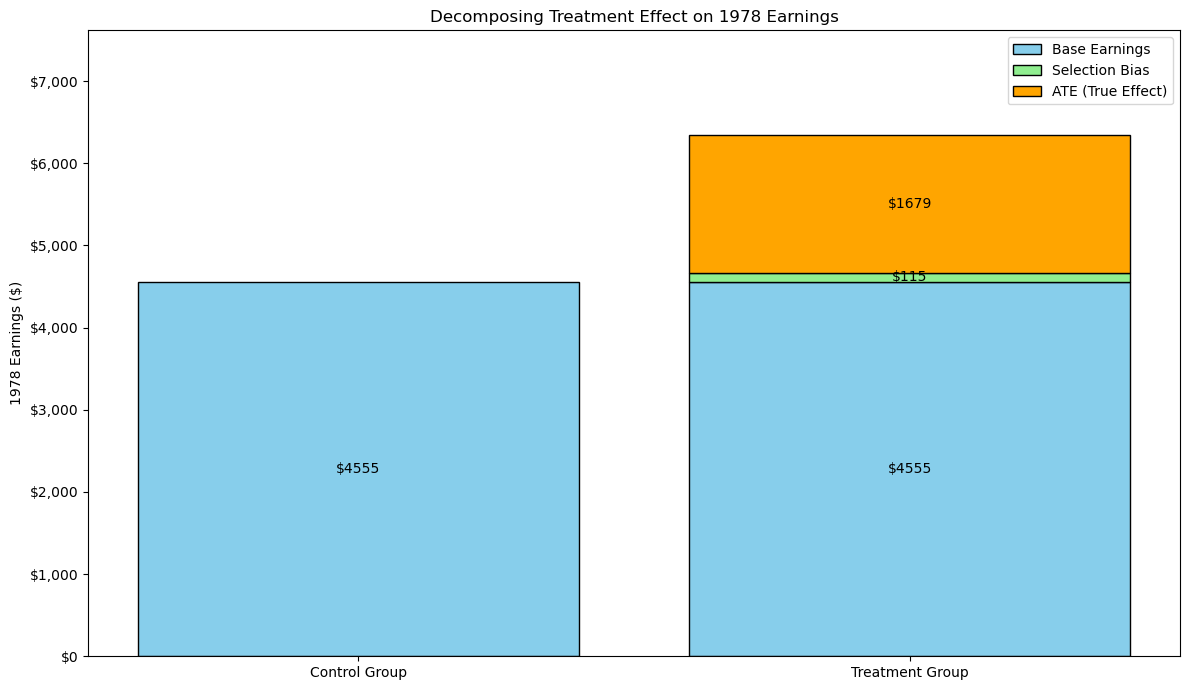

Control Group Average Earnings: $4554.80
Treatment Group Average Earnings: $6349.14
Average Treatment Effect (ATE): $1679.24
Selection Bias: $115.11


In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate necessary data
control_earnings = data[data['treat'] == 0]['re78'].mean()
treatment_earnings = data[data['treat'] == 1]['re78'].mean()
ate = estimate.value

# Calculate selection bias
selection_bias = treatment_earnings - control_earnings - ate

# Create the plot
fig, ax = plt.subplots(figsize=(12, 7))

# Create bars for control group and treatment group
ax.bar('Control Group', control_earnings, color='skyblue', edgecolor='black', label='Base Earnings')
ax.bar('Treatment Group', control_earnings, color='skyblue', edgecolor='black')

# Stack bars for selection bias and ATE
ax.bar('Treatment Group', selection_bias, bottom=control_earnings, color='lightgreen', edgecolor='black', label='Selection Bias')
ax.bar('Treatment Group', ate, bottom=control_earnings + selection_bias, color='orange', edgecolor='black', label='ATE (True Effect)')

# Add text labels
ax.text(0, control_earnings / 2, f'${control_earnings:.0f}', ha='center', va='center', color='black', fontsize=10)
ax.text(1, control_earnings / 2, f'${control_earnings:.0f}', ha='center', va='center', color='black', fontsize=10)
ax.text(1, control_earnings + selection_bias / 2, f'${selection_bias:.0f}', ha='center', va='center', color='black', fontsize=10)
ax.text(1, control_earnings + selection_bias + ate / 2, f'${ate:.0f}', ha='center', va='center', color='black', fontsize=10)

# Customize the plot
ax.set_ylim(0, treatment_earnings * 1.2)
ax.set_ylabel('1978 Earnings ($)')
ax.set_title('Decomposing Treatment Effect on 1978 Earnings')

# Add legend
ax.legend()

# Set Y-axis format
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '${:,.0f}'.format(y)))

plt.tight_layout()
plt.show()

# Output results
print(f"Control Group Average Earnings: ${control_earnings:.2f}")
print(f"Treatment Group Average Earnings: ${treatment_earnings:.2f}")
print(f"Average Treatment Effect (ATE): ${ate:.2f}")
print(f"Selection Bias: ${selection_bias:.2f}")


For this demo, we used DML, but the meta-learners in econml can utilize various methods.
To decide which meta-learner method to use, follow the steps below.
 
Here are the recommended steps:
- Step 1. Start simple. I recommend starting with simpler models like the S-learner or T-learner to get a baseline of the treatment effects.
- Step 2. In the next phase, try various methods and compare them. I recommend using predictive accuracy metrics such as MAPE or RMSE and refutation tests.
- Step 3. Perform cross-validation and hyperparameter tuning.
